In [1]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtree

import numpy as np
import optax
import pandas as pd 
import matplotlib.pyplot as plt

from dln import (
    create_dln_model, 
    create_minibatches, 
    true_dln_learning_coefficient, 
    mse_loss, 
)
from sgld_utils import (
    SGLDConfig, 
    run_sgld
)
from utils import to_json_friendly_tree, running_mean



import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd
import seaborn as sns


def orthogonal_vector(v):
    v = jnp.asarray(v)
    
    # Find a vector that is not parallel to v
    if v[0] != 0:
        basis = jnp.array([1.0] + [0.0] * (v.shape[0] - 1))
    else:
        basis = jnp.array([0.0, 1.0] + [0.0] * (v.shape[0] - 2))
    
    # Compute the orthogonal vector using the cross product (in higher dimensions, Gram-Schmidt can be used)
    orthogonal_v = jnp.cross(v, basis) if v.shape[0] == 3 else gram_schmidt(v, basis)
    
    return orthogonal_v

def gram_schmidt(v, basis):
    # Project basis onto v and subtract to make it orthogonal
    projection = jnp.dot(basis, v) / jnp.dot(v, v) * v
    orthogonal_v = basis - projection
    return orthogonal_v

def make_orthogonal_row(matrix):
    matrix = jnp.asarray(matrix)
    orthogonal_rows = jnp.stack(
        [orthogonal_vector(matrix[i, :]) for i in range(matrix.shape[0])], 
        axis=0
    )
    return orthogonal_rows



def estimate_cross_correlation_matrix(X, Y):
    # Ensure X and Y have the same number of samples
    assert X.shape[0] == Y.shape[0], "X and Y must have the same number of samples"
    
    n = X.shape[0]
    
    # Compute the non-centered cross covariance matrix
    C_XY = np.dot(X.T, Y) / n
    
    return C_XY


In [196]:

expt_name = "dln_stagewise_learning"
do_llc_estimation = False
in_out_dim = 5
sgld_config = {
        'epsilon': 1e-6,
        'gamma': 1.0,
        'num_steps': 100,
        "num_chains": 1, 
        "batch_size": 128
    }
loss_trace_minibatch = True
width = in_out_dim
initialisation_exponent = 5
num_hidden_layers = 1
num_training_data = 10000
itemp = 1 / np.log(num_training_data)
training_config = {
    "optim": "sgd", 
    "learning_rate": 1e-4, 
    "momentum": None, 
    "batch_size": 128, 
    "num_steps": 160000
}
seed = 1
logging_period = 500
verbose = True

output_noise_std = 0.1

# seeding
np.random.seed(seed)
rngkey = jax.random.PRNGKey(seed)

####################
# Initialisations
####################
# Teacher matrix
# teacher_matrix = 10 * np.diag(np.arange(in_out_dim, stop=0, step=-1))

teacher_matrix = np.diag([50, 40, 30, 20, 10])
# teacher_matrix = np.diag([30, 20, 10])

# teacher_matrix = np.random.randn(in_out_dim, in_out_dim) * 10
# np.fill_diagonal(teacher_matrix, 0.0)

feature_dim = teacher_matrix.shape[0]
output_dim = teacher_matrix.shape[1]
layer_widths = [width] * num_hidden_layers + [output_dim]

# Training data from teacher matrix
rngkey, rngkey = jax.random.split(rngkey)
corr = np.array([[1.4864248 , 0.6363192 , 0.4873521 , 1.2613461 , 0.409494  ],
       [0.6363192 , 1.9702207 , 1.1763477 , 0.83012015, 0.83204657],
       [0.4873521 , 1.1763477 , 2.089141  , 0.31718996, 0.7990399 ],
       [1.2613461 , 0.83012015, 0.31718996, 1.3778001 , 0.49159858],
       [0.40949404, 0.8320467 , 0.7990399 , 0.49159864, 1.3648908 ]],      dtype=np.float32)
x_train = jax.random.multivariate_normal(rngkey, jnp.zeros(feature_dim), corr, shape=(num_training_data,), dtype=jnp.float32)
# x_train = jax.random.normal(rngkey, shape=(num_training_data, feature_dim))
rngkey, rngkey = jax.random.split(rngkey)
y_train = x_train @ teacher_matrix + jax.random.normal(rngkey, shape=(num_training_data, output_dim)) * output_noise_std

# DLN model
initialisation_sigma = np.sqrt(width ** (-initialisation_exponent))
model = create_dln_model(layer_widths, sigma=initialisation_sigma)
loss_fn = jax.jit(lambda param, inputs, targets: mse_loss(param, model, inputs, targets))


rngkey, subkey = jax.random.split(rngkey)
init_param = model.init(rngkey, jnp.zeros((1, feature_dim)))
# w2 = init_param["deep_linear_network/linear"]["w"]
# init_param["deep_linear_network/linear_1"]["w"] = make_orthogonal_row(w2).T
# init_param = jtree.tree_map(lambda x: x * 10, init_param)



print("Model initialised with shapes:")
jtree.tree_map(lambda x: print(x.shape), init_param)

##############################################
# Train the model and do SGLD at some interval
##############################################

sgld_config = SGLDConfig(**sgld_config)

optimizer = optax.sgd(learning_rate=training_config["learning_rate"])
max_steps = training_config["num_steps"]
t = 0
rngkey, subkey = jax.random.split(rngkey)
grad_fn = jax.jit(jax.value_and_grad(loss_fn, argnums=0))
trained_param = init_param
opt_state = optimizer.init(trained_param)

input_output_correlation_matrix = (x_train.T @ y_train) / num_training_data
input_correlation_matrix = (x_train.T @ x_train) / num_training_data



info = []
while t < max_steps:
    for x_batch, y_batch in create_minibatches(x_train, y_train, batch_size=training_config["batch_size"]):
        train_loss, grads = grad_fn(trained_param, x_batch, y_batch)
        updates, opt_state = optimizer.update(grads, opt_state)
        trained_param = optax.apply_updates(trained_param, updates)
        
        if t % logging_period == 0:
                
            rec = {
                "t": t + 1, 
                "train_loss": float(train_loss),
                "trained_param": trained_param,
            }
            
            if do_llc_estimation:
                rngkey, subkey = jax.random.split(rngkey)
                y_realisable = model.apply(trained_param, x_train) #+ jax.random.normal(subkey, shape=(num_training_data, output_dim)) * output_noise_std
                y_train = y_realisable
                # y = y_train

                rngkey, subkey = jax.random.split(rngkey)
                loss_trace, distances, acceptance_probs = run_sgld(
                    subkey, 
                    loss_fn, 
                    sgld_config, 
                    trained_param, 
                    x_train, 
                    y_train,
                    itemp=itemp, 
                    trace_batch_loss=loss_trace_minibatch, 
                    compute_distance=False, 
                    verbose=False, 
                    compute_mala_acceptance=False
                )
                
                init_loss = loss_fn(trained_param, x_train, y_train)
                lambdahat = float(np.mean(loss_trace) - init_loss) * num_training_data * itemp

                true_matrix = jnp.linalg.multi_dot(
                    [trained_param[f'deep_linear_network/linear{loc}']['w'] for loc in [''] + [f'_{i}' for i in range(1, len(layer_widths))]]
                )
                true_rank = jnp.linalg.matrix_rank(true_matrix)
                true_lambda, true_multiplicity = true_dln_learning_coefficient(
                    true_rank, 
                    layer_widths, 
                    feature_dim, 
                )
            
                rec.update(
                    {
                        "lambdahat": float(lambdahat),
                        "true_lambda": true_lambda, 
                        "true_multiplicity": true_multiplicity, 
                        "loss_trace": loss_trace, 
                        "true_rank": true_rank,
                        "init_loss": float(init_loss),
                    }
                )
            if verbose and t % 1000 == 0:
                print(
                    f"t: {t + 1}, "
                    + f"train_loss: {float(train_loss):.4f}, "
                    + (f"lambdahat: {lambdahat:.4f}, " if do_llc_estimation else "")
                )

            info.append(to_json_friendly_tree(rec))
        
        t += 1
        if t >= max_steps:
            break


Model initialised with shapes:
(5, 5)
(5, 5)
t: 1, train_loss: 1618.0448, 
t: 1001, train_loss: 766.1100, 
t: 2001, train_loss: 565.7222, 
t: 3001, train_loss: 253.5149, 
t: 4001, train_loss: 208.9798, 
t: 5001, train_loss: 70.5055, 
t: 6001, train_loss: 43.5878, 
t: 7001, train_loss: 34.2384, 
t: 8001, train_loss: 28.5349, 
t: 9001, train_loss: 31.8366, 
t: 10001, train_loss: 29.2508, 
t: 11001, train_loss: 30.3349, 
t: 12001, train_loss: 23.5753, 
t: 13001, train_loss: 20.0097, 
t: 14001, train_loss: 21.4842, 
t: 15001, train_loss: 18.5019, 
t: 16001, train_loss: 15.2737, 
t: 17001, train_loss: 11.0358, 
t: 18001, train_loss: 16.0847, 
t: 19001, train_loss: 14.5779, 
t: 20001, train_loss: 9.6821, 
t: 21001, train_loss: 15.4930, 
t: 22001, train_loss: 14.1723, 
t: 23001, train_loss: 12.5392, 
t: 24001, train_loss: 15.3494, 
t: 25001, train_loss: 12.0805, 
t: 26001, train_loss: 13.3320, 
t: 27001, train_loss: 13.8224, 
t: 28001, train_loss: 14.3105, 
t: 29001, train_loss: 14.0641, 
t: 

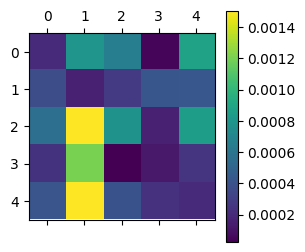

In [197]:
init_prod_mat = jnp.linalg.multi_dot(
    [
        jnp.array(init_param[f'deep_linear_network/linear{loc}']['w']) 
            for loc in [''] + [f'_{i}' for i in range(1, len(layer_widths))]
    ]
)
fig, ax = plt.subplots(figsize=(3, 3))
cax = ax.matshow(np.abs(init_prod_mat), cmap='viridis')
fig.colorbar(cax)


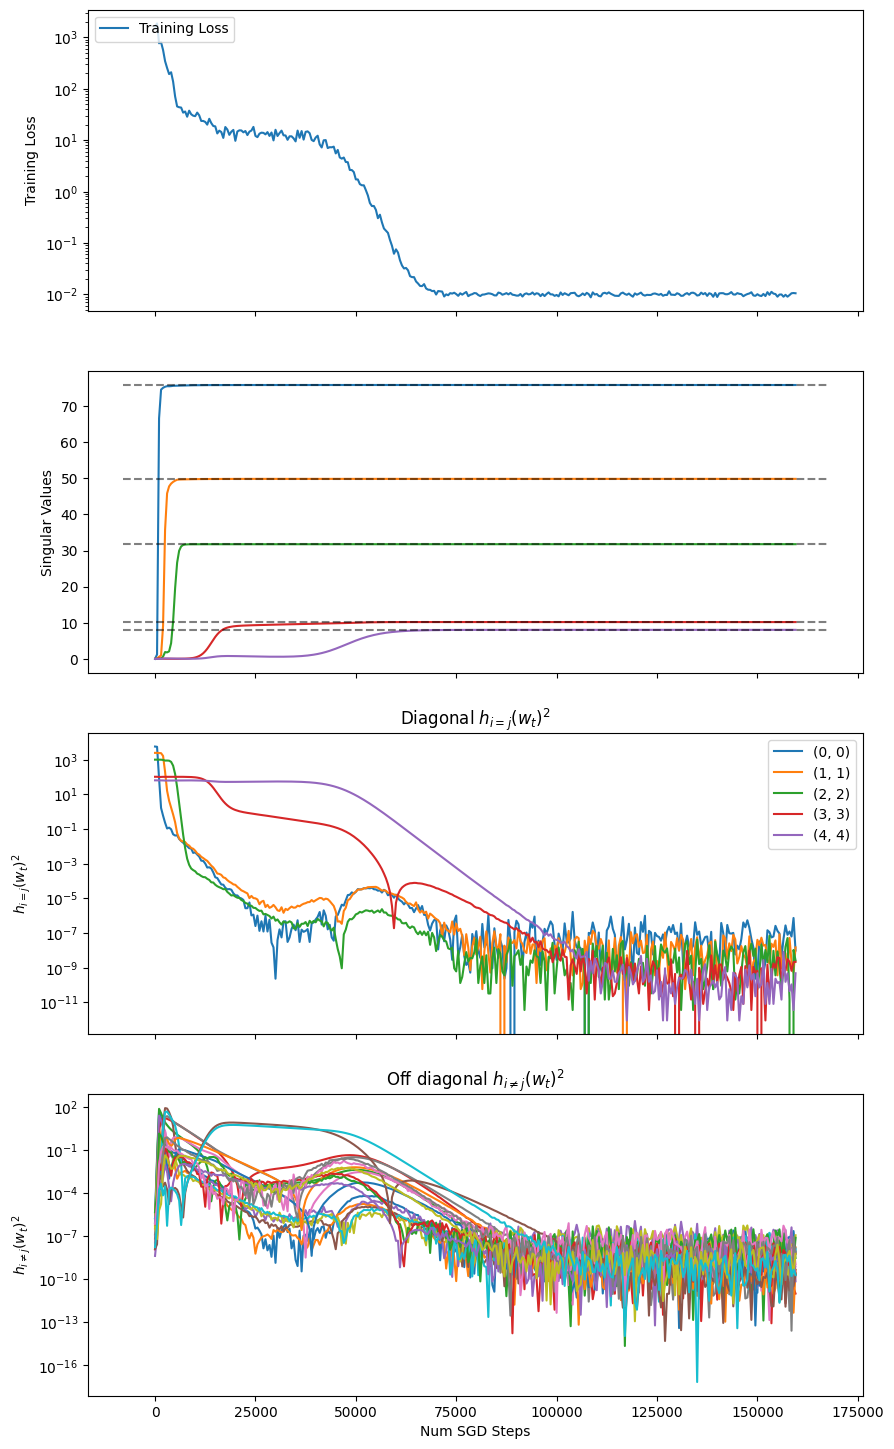

In [268]:
df = pd.DataFrame(info)
df["total_matrix"] = [
        jnp.linalg.multi_dot(
            [
                jnp.array(param[f'deep_linear_network/linear{loc}']['w']) 
                    for loc in [''] + [f'_{i}' for i in range(1, len(layer_widths))]
            ]
        ) for param in df["trained_param"]
]
df["singular_values"] = df["total_matrix"].apply(lambda x: np.linalg.svd(x, compute_uv=False))
input_correlation_matrix = x_train.T @ x_train / num_training_data
# input_correlation_matrix = corr
eigvals, eigvecs = np.linalg.eigh(input_correlation_matrix)
feature_output_cross_correlation = y_train.T @ x_train / num_training_data
ChangeOfBasis = eigvecs @ np.diag(eigvals ** (-1/2))
modified_feature_output_cross_correlation = feature_output_cross_correlation @ ChangeOfBasis
Ubar, Sbar, Vbar = np.linalg.svd(modified_feature_output_cross_correlation)


df["modified_total_matrix"] = df["total_matrix"].apply(lambda x: input_correlation_matrix @ x)
df["modified_singular_values"] = df["modified_total_matrix"].apply(lambda x: np.linalg.svd(x, compute_uv=False))


df["corrected_total_matrix"] = df["total_matrix"].apply(
    lambda total_mat: Ubar.T @ total_mat.T @ input_correlation_matrix @ ChangeOfBasis @ Vbar.T
)
df["corrected_singular_values"] = df["corrected_total_matrix"].apply(
    lambda x: [x[i, i] for i in range(min(x.shape[0], x.shape[1]))]
    # lambda x: np.linalg.svd(x, compute_uv=False)
)


df["potential_matrix"] = df["corrected_total_matrix"].apply(
    lambda x: x - np.diag(Sbar)
)


# df = df[df["t"] < 5000]


fig, axes = plt.subplots(4, 1, figsize=(10, 18), sharex=True)
ax = axes[0]
ax.plot(df["t"], df["train_loss"], label="Training Loss")
ax.set_ylabel("Training Loss")
ax.legend(loc="upper left")
ax.set_yscale("log")

if do_llc_estimation:
    ax = ax.twinx()
    ax.plot(df["t"], np.clip(df["lambdahat"], a_min=0, a_max=np.inf), "kx", alpha=0.3, label="Estimated LLC, $\hat{\lambda}(w^*)$")
    yvals = running_mean(df["lambdahat"])
    ax.plot(df["t"], yvals, "g-")
    ax.set_ylabel("Estimated LLC, $\hat{\lambda}(w^*)$")
    ax.legend(loc="upper right")


ax = axes[1]
key = "corrected_singular_values"
# key = "modified_singular_values"
# key = "singular_values"
for i in range(min(feature_dim, output_dim)):
    ax.plot(
        df["t"],
        df[key].apply(lambda x: x[i]), 
        label="$s_{" + str(i + 1) + "}$"
    )

xmin, xmax = ax.get_xlim()
singvals_true = Sbar
# _, singvals_true, _ = np.linalg.svd(feature_output_cross_correlation.T)
# _, singvals_true, _ = np.linalg.svd(teacher_matrix @ eigvecs @ np.diag(1/np.sqrt(eigvals)))
# singvals_true = np.linalg.svd(teacher_matrix, compute_uv=False)
# singvals_true = np.linalg.svd(teacher_matrix @ input_correlation_matrix, compute_uv=False)
# singvals_true = np.linalg.svd(feature_output_cross_correlation.T @ eigvecs @ np.diag(1/np.sqrt(eigvals)), compute_uv=False)
ax.hlines(singvals_true, xmin, xmax, color="k", linestyle="--", alpha=0.5)
ax.set_ylabel("Singular Values")



ax = axes[2]
for i in range(input_output_correlation_matrix.shape[0]):
    yvals = df["potential_matrix"].apply(lambda x: np.array(x)[i, i]**2)
    ax.plot(df["t"], yvals, label=f"({i}, {i})")
ax.set_ylabel("$h_{i=j}(w_t)^2$")
ax.set_title("Diagonal $h_{i=j}(w_t)^2$")
ax.legend()
ax.set_yscale("log")

ax = axes[3]
for i in range(input_output_correlation_matrix.shape[0]):
    for j in range(input_output_correlation_matrix.shape[1]):
        if i == j: continue # only plot the off diagonal elements
        yvals = df["potential_matrix"].apply(lambda x: np.array(x)[i, j]**2)
        ax.plot(df["t"], yvals, label=f"({i}, {j})")
ax.set_ylabel("$h_{i \\neq j}(w_t)^2$")
ax.set_title("Off diagonal $h_{i \\neq j}(w_t)^2$")
ax.set_yscale("log")
# ax.legend()



for i, ax in enumerate(axes): 
    if i == len(axes) - 1:
        ax.set_xlabel("Num SGD Steps")
    # ax.set_yscale("log")
    # ax.set_xscale("log")


In [ ]:
from matplotlib.colors import LogNorm

h_ij_sqvals = [np.array(x)**2 for x in df["potential_matrix"].to_list()][::3]
# Create a figure and axis
fig, ax = plt.subplots()
norm = LogNorm()
cax = ax.matshow(h_ij_sqvals[0], cmap='magma', norm=norm)
cbar = fig.colorbar(cax)

# Function to update the heatmap
def update(frame):
    cax.set_array(h_ij_sqvals[frame])
    return cax,

# Create an animation
ani = animation.FuncAnimation(fig, update, frames=len(h_ij_sqvals), blit=True)

HTML(ani.to_jshtml())
# ani.save("dln_stagewise_learning.mp4", fps=10)
# ! open dln_stagewise_learning.mp4

# Generating data using branching diffusion process on a fixed tree structure.

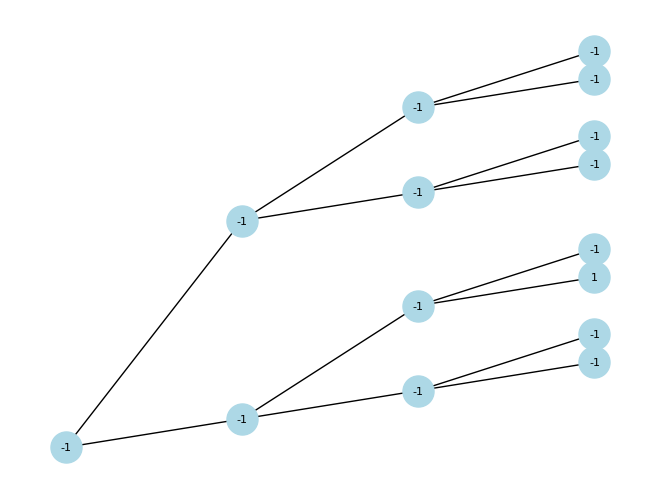

[-1, -1, 1, -1, -1, -1, -1, -1]


In [642]:
import networkx as nx
import matplotlib.pyplot as plt

class TreeNode:
    def __init__(self, value=None):
        self.value = value
        self.children = []

    def add_child(self, child_node):
        self.children.append(child_node)

class Tree:
    def __init__(self, branching_factors):
        self.root = TreeNode()
        self.branching_factors = branching_factors
        self.depth = len(branching_factors)

    def build_tree(self):
        self._build_subtree(self.root, 0)

    def _build_subtree(self, node, level):
        if level == self.depth:
            return
        for _ in range(self.branching_factors[level]):
            child_node = TreeNode()
            node.add_child(child_node)
            self._build_subtree(child_node, level + 1)

    def extract_feature_vector(self):
        leaves = []
        self._collect_leaves(self.root, leaves)
        return [leaf.value for leaf in leaves]

    def _collect_leaves(self, node, leaves):
        if not node.children:  # It's a leaf
            leaves.append(node)
        for child in node.children:
            self._collect_leaves(child, leaves)

def visualize_tree(tree):
    G = nx.DiGraph()
    pos = {}
    labels = {}
    idx = 0

    def add_edges(node, parent_idx=None, level=0):
        nonlocal idx
        current_idx = idx
        pos[current_idx] = (level, idx)
        labels[current_idx] = node.value if node.value is not None else ""
        G.add_node(current_idx)
        if parent_idx is not None:
            G.add_edge(parent_idx, current_idx)
        idx += 1
        for child in node.children:
            add_edges(child, current_idx, level + 1)

    add_edges(tree.root)
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=500, node_color='lightblue', font_size=8, arrows=False)
    plt.show()

import numpy as np

def assign_values_to_tree(tree, epsilon):
    def assign_value(node, parent_value=None):
        if parent_value is None:
            node.value = 1 if np.random.rand() > 0.5 else -1
        else:
            node.value = parent_value if np.random.rand() > epsilon else -parent_value
        for child in node.children:
            assign_value(child, node.value)

    assign_value(tree.root)

# Define branching factors
branching_factors = [2, 2, 2]  
epsilon = 0.1  

# Create and build the tree
tree = Tree(branching_factors)
tree.build_tree()

# Assign values to the tree
assign_values_to_tree(tree, epsilon)

# Visualize the tree
visualize_tree(tree)
print(tree.extract_feature_vector())

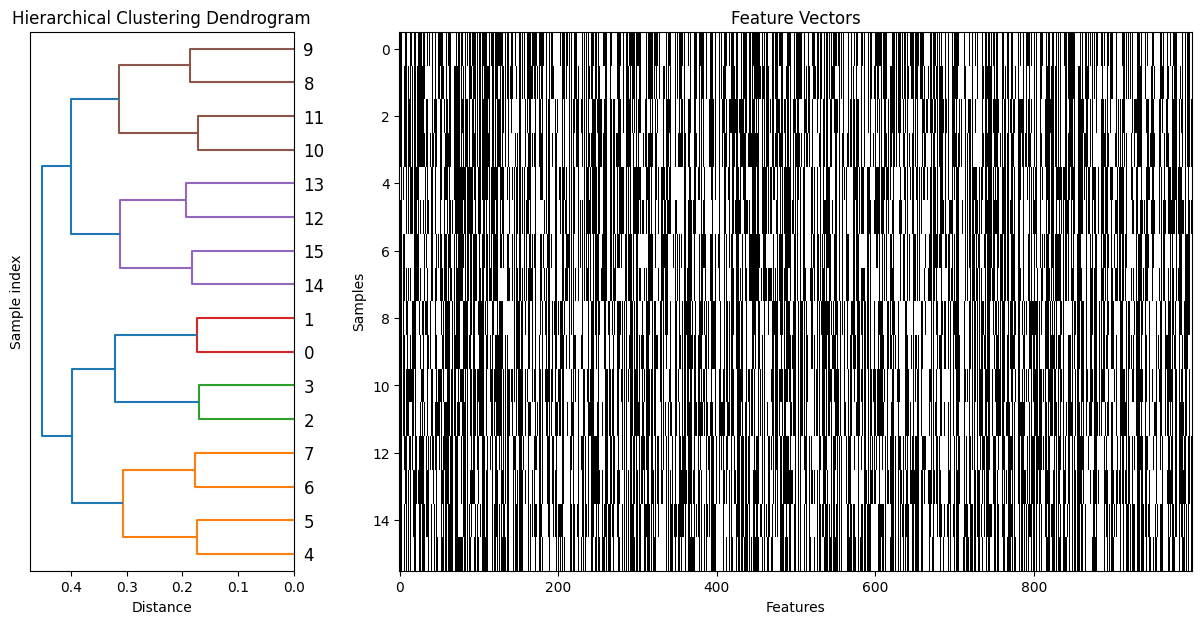

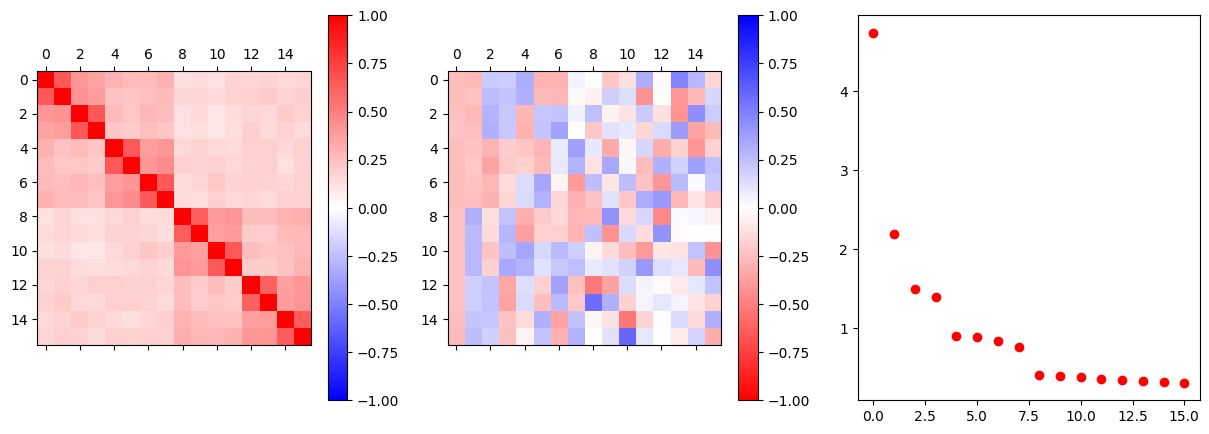

In [899]:
import numpy as np
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import scipy
import scipy.special


# Generate the data
num_features = 1000
branching_factors = [2, 2, 2, 2]
epsilon = 0.1

data = []
for _ in range(num_features):
    tree = Tree(branching_factors)
    tree.build_tree()
    assign_values_to_tree(tree, epsilon)
    data.append(tree.extract_feature_vector())

data = np.array(data).T  # Transpose to get a matrix with examples as rows and features as columns

# Perform hierarchical clustering
linked = sch.linkage(data, method='complete', metric="hamming")

# Create the dendrogram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), gridspec_kw={'width_ratios': [1, 3]})

# Plot the dendrogram
dendro = sch.dendrogram(linked, orientation='left', labels=np.arange(data.shape[0]), ax=ax1)
ax1.set_title('Hierarchical Clustering Dendrogram')
ax1.set_xlabel('Distance')
ax1.set_ylabel('Sample index')

# Reorder data according to clustering
reordered_data = data[dendro['leaves'], :]

# Plot the feature vectors as black and white squares
ax2.imshow(reordered_data, aspect='auto', cmap='gray', interpolation='nearest')
ax2.set_title('Feature Vectors')
ax2.set_xlabel('Features')
ax2.set_ylabel('Samples')


similarity_matrix = data @ data.T / num_features
U, S, V = np.linalg.svd(similarity_matrix)
difference_matrix = 1 - similarity_matrix

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
cmap = "bwr"
ax = axes[0]
# cax = ax.matshow(difference_matrix, cmap='viridis')
cax = ax.matshow(similarity_matrix, cmap=cmap, vmin=-1, vmax=1)
# cax = ax.matshow(scipy.special.softmax(-difference_matrix), cmap='viridis')
fig.colorbar(cax)


ax = axes[1]
# U = U * (np.abs(U) > 0.35)
cax = ax.matshow(U, cmap=cmap + "_r", vmin=-1, vmax=1)
fig.colorbar(cax)

ax = axes[2]
ax.plot(S, "ro")


# Non-linear toy example

In [2]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, random
import optax
from itertools import combinations_with_replacement


def polynomial_feature_map_jax(x, degree=2):
    """
    Compute the polynomial feature map for input vector x up to a specified degree using JAX.
    
    Parameters:
    x (array-like): Input vector of shape (n,).
    degree (int): Degree of the polynomial features.
    
    Returns:
    jnp.ndarray: Transformed feature vector including all monomials up to the specified degree.
    """
    n = len(x)
    features = [1.0]  # Start with the constant term 1
    
    # Generate all combinations of features up to the specified degree
    for d in range(1, degree + 1):
        for combination in combinations_with_replacement(range(n), d):
            product = jnp.prod(jnp.array([x[i] for i in combination]))
            features.append(product)
    
    return jnp.array(features)


def generate_sparse_random_matrix(key, shape, density):
    """Generate a sparse random matrix with given density.
    
    Args:
        key: PRNG key for random number generation.
        shape: Tuple specifying the shape of the matrix (rows, columns).
        density: Fraction of non-zero elements in the matrix.
        
    Returns:
        A sparse random matrix of the specified shape and density.
    """
    total_elements = shape[0] * shape[1]
    num_non_zero_elements = int(total_elements * density)

    # Generate random indices for the non-zero elements
    indices = jax.random.choice(key, total_elements, shape=(num_non_zero_elements,), replace=False)
    row_indices = indices // shape[1]
    col_indices = indices % shape[1]

    # Generate random values for the non-zero elements
    values = jax.random.normal(key, shape=(num_non_zero_elements,))

    # Create the sparse matrix
    sparse_matrix = jnp.zeros(shape)
    sparse_matrix = sparse_matrix.at[row_indices, col_indices].set(values)
    
    return sparse_matrix


# Data generation
def generate_data(key, feature_map, n_samples, input_dim, output_dim, A_true, sigma, input_sigma=1.0):
    x = random.normal(key, (n_samples, input_dim)) * input_sigma
    phi_x = vmap(feature_map)(x)
    y = phi_x @ A_true + random.normal(key, (n_samples, output_dim)) * sigma
    return x, y

In [288]:
expt_name = "toy_nonlinear_stagewise_learning"
do_llc_estimation = False

input_dim = 2
output_dim = 2
hidden_layer_widths = [7, 7]

sgld_config = {
    'epsilon': 1e-7,
    'gamma': 1.0,
    'num_steps': 1000,
    "num_chains": 1, # TODO: not implemented chains
    "batch_size": 128
}
data_config = {
    "num_training_data": 10000,
    "feature_map": None, # None, ("polynomial", d)
    "output_noise_std": 0.1, 
    "input_noise_std": 1.5,
    "teacher_matrix": "random", # diagonal, "sparse", 
    "sparsity": None, 
}
loss_trace_minibatch = True # if True loss_trace uses minibatch, else use full dataset. 
initialisation_exponent = 1.5
scale_init_param = .2

itemp = 1 / np.log(data_config["num_training_data"])
training_config = {
    "optim": "sgd", 
    "learning_rate": 0.0001, 
    "momentum": None, 
    "batch_size": 32, 
    "num_steps": 10001
}
seed = 42
logging_period = 500

# seeding
np.random.seed(seed)
rngkey = jax.random.PRNGKey(seed)

sgld_config = SGLDConfig(**sgld_config)



degree = 2
feature_map = lambda x: polynomial_feature_map_jax(x, degree)
x_dummy = jnp.ones(input_dim)
feat_x_dummy = feature_map(x_dummy)
feature_dim = len(feat_x_dummy)

print(f"Input dim: {input_dim}, feature dim {feature_dim}, output dim: {output_dim}")

####################
# Initialisations
####################
num_hidden_layers = len(hidden_layer_widths)
layer_widths = hidden_layer_widths + [output_dim]
num_layers = len(layer_widths)

# DLN model
initialisation_sigma = np.sqrt(np.mean(layer_widths) ** (-initialisation_exponent))
print(f"Initialisation sigma: {initialisation_sigma}")
model = create_dln_model(layer_widths, sigma=initialisation_sigma)
rngkey, subkey = jax.random.split(rngkey)
init_param = model.init(rngkey, feat_x_dummy)
print(f"Model parameter shapes: {jtree.tree_map(lambda x: x.shape, init_param)}")


# Model prediction function
def predict(param, x):
    phi_x = vmap(feature_map)(x)
    return model.apply(param, phi_x)

# Loss function
@jit
def loss_fn(params, x, y):
    y_pred = predict(params, x)
    return jnp.mean((y - y_pred) ** 2)

# Training function
@jit
def update(params, opt_state, batch):
    inputs, targets = batch
    grads = grad(loss_fn)(params, inputs, targets)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state


# True matrix A_true and data generation

rngkey, subkey = random.split(rngkey)
# sparsity = 0.2
# A_true = generate_sparse_random_matrix(rngkey, (feature_dim, output_dim), density=1 - sparsity)
# spectra = [30, 10, 8, 7.5, 7.0, 2.2, 1.0] 
# spectra += [0.0] * (max(feature_dim, output_dim) - len(spectra))
spectra = [20/i**0.8 for i in range(1, 1 + max(feature_dim, output_dim))]
A_true = np.diag(spectra)[:feature_dim, :output_dim]
# A_true = np.diag(np.arange(max(feature_dim, output_dim), 0, -1))[:feature_dim, :output_dim]
print(f"A_true shape: {A_true.shape}. Singular values: {np.linalg.svd(A_true)[1]}")


num_training_data = data_config["num_training_data"]
itemp = 1 / np.log(num_training_data)
sigma = 0.3
input_sigma = 1.0
rngkey, subkey = random.split(rngkey)
x_train, y_train = generate_data(
    rngkey, 
    feature_map, 
    num_training_data, 
    input_dim, 
    output_dim, 
    A_true, 
    data_config["output_noise_std"], 
    input_sigma=data_config["input_noise_std"]
)
phi_train = vmap(feature_map)(x_train)
feature_correlation_matrix = estimate_cross_correlation_matrix(phi_train, phi_train)
eigvals, eigvecs = np.linalg.eigh(feature_correlation_matrix)
order = np.argsort(eigvals)[::-1]
eigvals = eigvals[order]
eigvecs = eigvecs[:, order]
print(f"Feature correlation matrix shape: {feature_correlation_matrix.shape}")


if scale_init_param: 
    init_param = jtree.tree_map(lambda x: x * scale_init_param, init_param)

# Set up optimizer
learning_rate = training_config["learning_rate"]
optimizer = optax.sgd(learning_rate)
param = init_param
opt_state = optimizer.init(param)


# Training loop
t = 0
records = []
while t < training_config["num_steps"]:
    for batch in create_minibatches(x_train, y_train, batch_size=training_config["batch_size"]):
        param, opt_state = update(param, opt_state, batch)
        if t % logging_period == 0:
            current_loss = loss_fn(param, x_train, y_train)
            total_matrix = jnp.linalg.multi_dot(
                [param[f'deep_linear_network/linear{loc}']['w'] 
                 for loc in [''] + [f'_{i}' for i in range(1, num_layers)]]
            )
            # singvals= np.linalg.svd(total_matrix.T @ eigvecs @ np.diag(1 / np.sqrt(eigvals)) , compute_uv=False)
            singvals = np.linalg.svd(total_matrix, compute_uv=False)
            rec = {
                "t": t + 1,
                "train_loss": float(current_loss),
                "param": param, 
                "total_matrix": total_matrix, 
                "singular_values": singvals
            }
            if do_llc_estimation:
                y = predict(param, x_train)
                rngkey, subkey = jax.random.split(rngkey)
                loss_trace, distances, acceptance_probs = run_sgld(
                    subkey, 
                    loss_fn, 
                    sgld_config, 
                    param, 
                    x_train, 
                    y,
                    itemp=itemp, 
                    trace_batch_loss=True, 
                    compute_distance=False, 
                    verbose=False, 
                    compute_mala_acceptance=False
                )
                
                init_loss = loss_fn(param, x_train, y)
                burn_in_prop = 0.9
                burn_in = int(burn_in_prop * len(loss_trace))
                lambdahat = float(np.mean(loss_trace[burn_in:]) - init_loss) * num_training_data * itemp

                
                rec.update(
                    {
                        "lambdahat": float(lambdahat),
                        # "loss_trace": loss_trace, 
                        # "init_loss": float(init_loss),
                    }
                )
                print(f"t: {t + 1:7d}, Loss: {current_loss:5.5f}, LLC: {lambdahat:3.3f}")
            records.append(rec)
            
        t += 1
        if t >= training_config["num_steps"]:
            break


Input dim: 2, feature dim 6, output dim: 2
Initialisation sigma: 0.2849383821193472
Model parameter shapes: {'deep_linear_network/linear': {'w': (6, 7)}, 'deep_linear_network/linear_1': {'w': (7, 7)}, 'deep_linear_network/linear_2': {'w': (7, 2)}}
A_true shape: (6, 2). Singular values: [20.         11.48698355]
Feature correlation matrix shape: (6, 6)


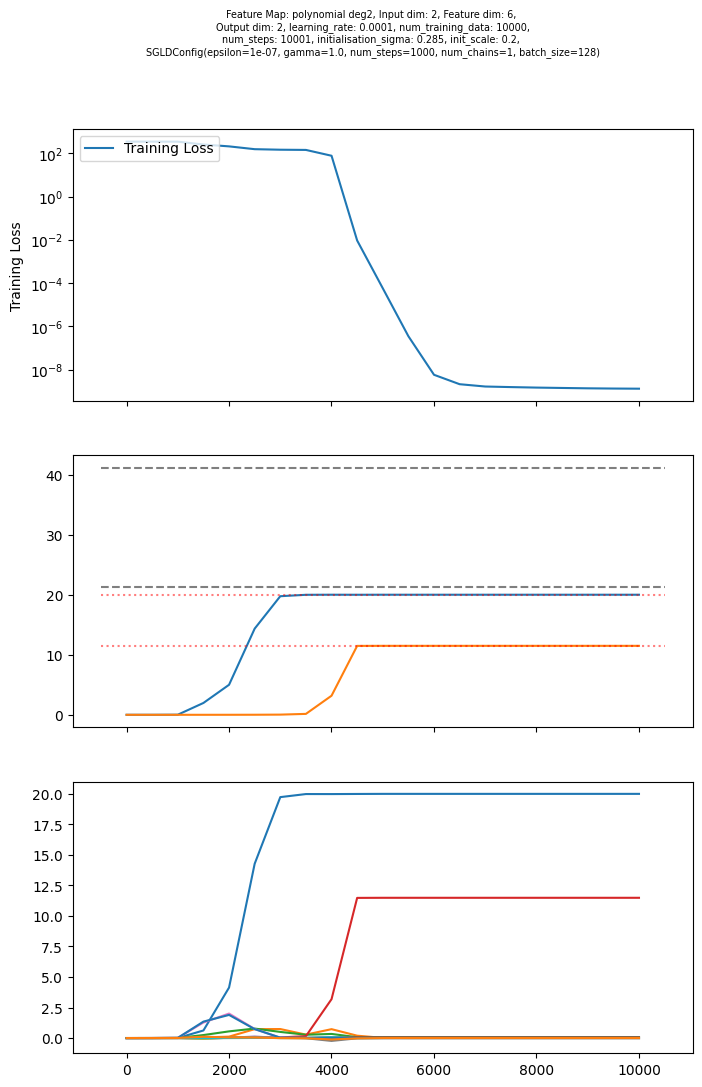

In [290]:

df_data = pd.DataFrame(records)

df = df_data
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)
ax = axes[0]
ax.plot(df["t"], df["train_loss"], label="Training Loss")
ax.set_ylabel("Training Loss")
ax.legend(loc="upper left")
ax.set_yscale("log")

if do_llc_estimation:
    ax = ax.twinx()
    xvals = np.array(df["t"])
    yvals = np.array(df["lambdahat"])
    maxval = 200
    mask = yvals < maxval
    xvals = xvals[mask]
    yvals = yvals[mask]
    ax.plot(xvals, yvals, "kx", alpha=0.3, label="Estimated LLC, $\hat{\lambda}(w^*)$")
    yvals = running_mean(yvals, window_size=10)
    ax.plot(xvals, yvals, "g-")
    ax.set_ylabel("Estimated LLC, $\hat{\lambda}(w^*)$")
    ax.legend(loc="upper right")


ax = axes[1]
for i in range(min(feature_dim, output_dim)):
    ax.plot(
        df["t"],
        df["singular_values"].apply(lambda x: x[i]), 
        label="$s_{" + str(i + 1) + "}$"
    )

xmin, xmax = ax.get_xlim()
phi_train = vmap(feature_map)(x_train)
feature_correlation_matrix = estimate_cross_correlation_matrix(phi_train, phi_train)
eigvals, eigvecs = np.linalg.eigh(feature_correlation_matrix)
order = np.argsort(eigvals)[::-1]
eigvals = eigvals[order]
eigvecs = eigvecs[:, order]
feature_output_cross_correlation = phi_train.T @ y_train / num_training_data
# _, singvals_true, _ = np.linalg.svd(A_true.T @ eigvecs @ np.diag(np.sqrt(eigvals)))
_, singvals_true, _ = np.linalg.svd(feature_output_cross_correlation.T @ eigvecs.T @ np.diag(1 / np.sqrt(eigvals)))
ax.hlines(singvals_true, xmin, xmax, color="k", linestyle="--", alpha=0.5)
# ax.legend()

_, singvals_true, _ = np.linalg.svd(A_true)
ax.hlines(singvals_true, xmin, xmax, color="r", linestyle="dotted", alpha=0.5)


ax = axes[2]
for i in range(feature_dim):
    for j in range(output_dim):
        ax.plot(df["t"], df["total_matrix"].apply(lambda x: np.array(x)[i, j]), label=f"({i}, {j})")



for ax in axes:
    # ax.set_yscale("log")
    # ax.set_xscale('log')
    pass

suptitle = (
    f"Feature Map: polynomial deg{degree}, "
    f"Input dim: {input_dim}, "
    f"Feature dim: {feature_dim}, \n"
    f"Output dim: {output_dim}, "
    # f"A_true singular values: {list(np.linalg.svd(A_true)[1])}, "
    f"learning_rate: {learning_rate}, "
    f"num_training_data: {num_training_data},\n"
    f"num_steps: {training_config['num_steps']}, "
    f"initialisation_sigma: {initialisation_sigma:.3f}, "
    f"init_scale: {scale_init_param}, "
    f"\n{sgld_config}"
)
# if do_llc_estimation:
#     suptitle += '\n' + ', '.join([f"{k}: {v}" for k, v in sgld_config])
fig.suptitle(suptitle, fontsize="x-small");

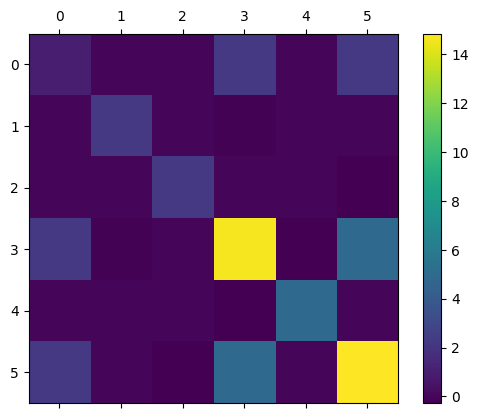

In [278]:
fig, ax = plt.subplots()
mu_vec = np.mean(phi_train, axis=0)
cax = ax.matshow(feature_correlation_matrix, cmap="viridis")
fig.colorbar(cax)


In [248]:
#TODO: visualise the dot product between the weights to see if they are orthogonal. 

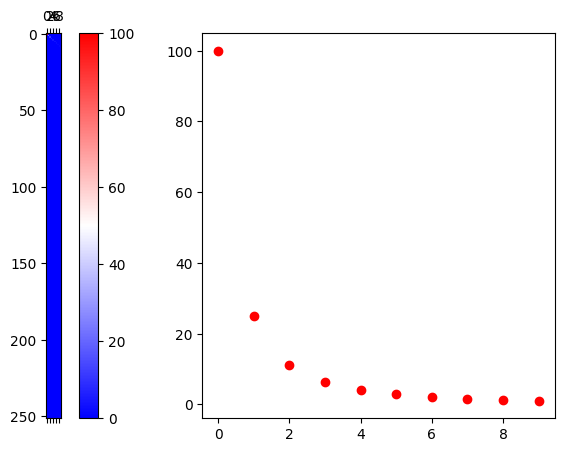

In [450]:
U, S, V = np.linalg.svd(A_true)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
cmap = "bwr"
ax = axes[0]
cax = ax.matshow(A_true, cmap=cmap)
fig.colorbar(cax)

ax = axes[1]
ax.plot(S, "ro")


# Learnt feature map

In [3]:
import haiku as hk
import json
class MLP(hk.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layer_sizes = layer_sizes

    def __call__(self, x):
        for size in self.layer_sizes[:-1]:
            x = hk.Linear(size)(x)
            x = jax.nn.relu(x)
        # Output layer (no activation)
        x = hk.Linear(self.layer_sizes[-1])(x)
        return x

# Define the forward function
def mlp_forward_fn(x, layer_sizes):
    mlp = MLP(layer_sizes)
    return mlp(x)

# Transform the forward function
def create_mlp_fn(layer_sizes):
    return hk.without_apply_rng(hk.transform(lambda x: mlp_forward_fn(x, layer_sizes)))


def param_dist(param1, param2, ord=2):
    return np.sum(jtree.tree_leaves(jtree.tree_map(lambda x, y: np.sum((x - y)**ord), param1, param2)))**(1/ord)


In [69]:
expt_name = "learnt_featuremap_stagewise_learning"
do_llc_estimation = False

input_dim = 3
output_dim = 5
hidden_layer_widths = [10, 10, 10]

sgld_config = {
    'epsilon': 5e-9,
    'gamma': 1.0,
    'num_steps': 200,
    "num_chains": 1, # TODO: not implemented chains
    "batch_size": 256
}
data_config = {
    "num_training_data": 100001,
    "feature_map": None, # None, ("polynomial", d)
    "output_noise_std": 0.1, 
    "input_noise_std": 5.0,
    "teacher_matrix": "random", # diagonal, "sparse", 
    "sparsity": None, 
}
loss_trace_minibatch = True # if True loss_trace uses minibatch, else use full dataset. 
initialisation_exponent = 1.5
scale_init_param = .5

itemp = 1 / np.log(data_config["num_training_data"])
training_config = {
    "optim": "sgd", 
    "learning_rate": 0.000005, 
    "momentum": None, 
    "batch_size": 16, 
    "num_steps": 300001
}
seed = 42
logging_period = 1000

# seeding
np.random.seed(seed)
rngkey = jax.random.PRNGKey(seed)

sgld_config = SGLDConfig(**sgld_config)



degree = 3
feature_map = lambda x: polynomial_feature_map_jax(x, degree)
x_dummy = jnp.ones(input_dim)
feat_x_dummy = feature_map(x_dummy)
feature_dim = len(feat_x_dummy)

print(f"Input dim: {input_dim}, feature dim {feature_dim}, output dim: {output_dim}")

####################
# Initialisations
####################
num_hidden_layers = len(hidden_layer_widths)
layer_widths = hidden_layer_widths + [output_dim]
num_layers = len(layer_widths)
print(f"Layer widths: {layer_widths}")

# DLN model
initialisation_sigma = np.sqrt(np.mean(layer_widths) ** (-initialisation_exponent))
print(f"Initialisation sigma: {initialisation_sigma}")
model_dln = create_dln_model(layer_widths, sigma=initialisation_sigma)
rngkey, subkey = jax.random.split(rngkey)
init_param = model_dln.init(rngkey, feat_x_dummy)
print(f"Model parameter shapes:")
print(jtree.tree_map(lambda x: x.shape, init_param))


# MLP feature network model
mlp_layer_widths = [32, 16, feature_dim]
model_feat = create_mlp_fn(mlp_layer_widths)
rngkey, subkey = jax.random.split(rngkey)
init_param_feature_network = model_feat.init(rngkey, x_dummy)
print(f"Feature network parameter shapes:")
print(jtree.tree_map(lambda x: x.shape, init_param_feature_network))
print(f"Feature network output shape: {model_feat.apply(init_param_feature_network, jnp.ones((23, input_dim))).shape}")





# Model prediction function
def predict(param, x):
    param_dln, param_feature_network = param
    phi_x = model_feat.apply(param_feature_network, x)
    print(f"phi_x shape: {phi_x.shape}")
    return model_dln.apply(param_dln, phi_x)

# Loss function
@jit
def loss_fn(params, x, y):
    y_pred = predict(params, x)
    return jnp.mean((y - y_pred) ** 2)

# Training function
@jit
def update(params, opt_state, batch):
    inputs, targets = batch
    grads = grad(loss_fn)(params, inputs, targets)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state


# True matrix A_true and data generation

rngkey, subkey = random.split(rngkey)
# A_true = np.random.normal(size=(feature_dim, output_dim)) * 5
# sparsity = 0.3
# A_true = generate_sparse_random_matrix(rngkey, (feature_dim, output_dim), density=1 - sparsity)
# spectra = [30, 10, 8, 7.5, 7.0, 2.2, 1.0] 
# spectra += [0.0] * (max(feature_dim, output_dim) - len(spectra))
spectra = [20/i**1.5 for i in range(1, 1 + max(feature_dim, output_dim))]
A_true = np.diag(spectra)[:feature_dim, :output_dim]
# A_true = np.diag(np.arange(max(feature_dim, output_dim), 0, -1))[:feature_dim, :output_dim]
print(f"A_true shape: {A_true.shape}. Singular values: {np.linalg.svd(A_true)[1]}")


num_training_data = data_config["num_training_data"]
itemp = 1 / np.log(num_training_data)
sigma = 0.3
input_sigma = 1.0
rngkey, subkey = random.split(rngkey)
x_train, y_train = generate_data(
    rngkey, 
    feature_map, 
    num_training_data, 
    input_dim, 
    output_dim, 
    A_true, 
    data_config["output_noise_std"], 
    input_sigma=data_config["input_noise_std"]
)
rngkey, subkey = random.split(rngkey)
x_test, y_test = generate_data(
    rngkey, 
    feature_map, 
    num_training_data // 5, 
    input_dim, 
    output_dim, 
    A_true, 
    data_config["output_noise_std"], 
    input_sigma=data_config["input_noise_std"]
)



if scale_init_param: 
    init_param = jtree.tree_map(lambda x: x * scale_init_param, init_param)

# Set up optimizer
learning_rate = training_config["learning_rate"]
# optimizer = optax.sgd(learning_rate)
optimizer = optax.adam(learning_rate)
param = [init_param, init_param_feature_network]
param_previous = param
opt_state = optimizer.init(param)


# Training loop
t = 0
records = []
while t < training_config["num_steps"]:
    for batch in create_minibatches(x_train, y_train, batch_size=training_config["batch_size"]):
        param, opt_state = update(param, opt_state, batch)
        if t % logging_period == 0:
            param_dln, param_feat = param
            current_loss = loss_fn(param, x_train, y_train)
            test_loss = loss_fn(param, x_test, y_test)
            total_matrix = jnp.linalg.multi_dot(
                [param_dln[f'deep_linear_network/linear{loc}']['w'] 
                 for loc in [''] + [f'_{i}' for i in range(1, num_layers)]]
            )
            rec = {
                "t": t + 1,
                "train_loss": float(current_loss),
                "test_loss": float(test_loss),
                "param": param, 
                "total_matrix": total_matrix, 
            }
            if do_llc_estimation:
                y = predict(param, x_train)
                rngkey, subkey = jax.random.split(rngkey)
                loss_trace, distances, acceptance_probs = run_sgld(
                    subkey, 
                    loss_fn, 
                    sgld_config, 
                    param, 
                    x_train, 
                    y,
                    itemp=itemp, 
                    trace_batch_loss=True, 
                    compute_distance=False, 
                    verbose=False, 
                    compute_mala_acceptance=False
                )
                
                init_loss = loss_fn(param, x_train, y)
                burn_in_prop = 0.9
                burn_in = int(burn_in_prop * len(loss_trace))
                lambdahat = float(np.mean(loss_trace[burn_in:]) - init_loss) * num_training_data * itemp

                
                rec.update(
                    {
                        "lambdahat": float(lambdahat),
                        # "loss_trace": loss_trace, 
                        # "init_loss": float(init_loss),
                    }
                )
            print(
                f"t: {t + 1:7d}, "
                f"Loss: {current_loss:5.5f}, "
                + (f"LLC: {lambdahat:3.3f}" if do_llc_estimation else ""))
            records.append(rec)

            # dist = np.sqrt(np.sum(jtree.tree_leaves(jtree.tree_map(lambda x, y: np.sum((x - y)**2), param_feat, param_previous[1]))))
            dist = param_dist(param_previous[1], param_feat)
            dist_init = param_dist(init_param_feature_network, param_feat)
            rec.update(
                {
                    "dist": dist,
                    "dist_init": dist_init
                }
            )
            param_previous = param
            
        t += 1
        if t >= training_config["num_steps"]:
            break


Input dim: 3, feature dim 20, output dim: 5
Layer widths: [10, 10, 10, 5]
Initialisation sigma: 0.196559464471451
Model parameter shapes:
{'deep_linear_network/linear': {'w': (20, 10)}, 'deep_linear_network/linear_1': {'w': (10, 10)}, 'deep_linear_network/linear_2': {'w': (10, 10)}, 'deep_linear_network/linear_3': {'w': (10, 5)}}
Feature network parameter shapes:
{'mlp/linear': {'b': (32,), 'w': (3, 32)}, 'mlp/linear_1': {'b': (16,), 'w': (32, 16)}, 'mlp/linear_2': {'b': (20,), 'w': (16, 20)}}
Feature network output shape: (23, 20)
A_true shape: (20, 5). Singular values: [20.          7.07106781  3.84900179  2.5         1.78885438]
phi_x shape: (16, 20)
phi_x shape: (100001, 20)
phi_x shape: (20000, 20)
t:       1, Loss: 1617.45923, 
t:    1001, Loss: 1616.81433, 
t:    2001, Loss: 1615.59497, 
t:    3001, Loss: 1613.17249, 
t:    4001, Loss: 1608.87476, 
t:    5001, Loss: 1601.62781, 
t:    6001, Loss: 1590.30115, 
t:    7001, Loss: 1572.93787, 
t:    8001, Loss: 1548.27710, 
t:    90

/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_47852/1691851105.py:12: RuntimeWarning: invalid value encountered in power
  ChangeOfBasis = eigvecs @ np.diag(eigvals ** (-1/2))
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_47852/1691851105.py:118: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


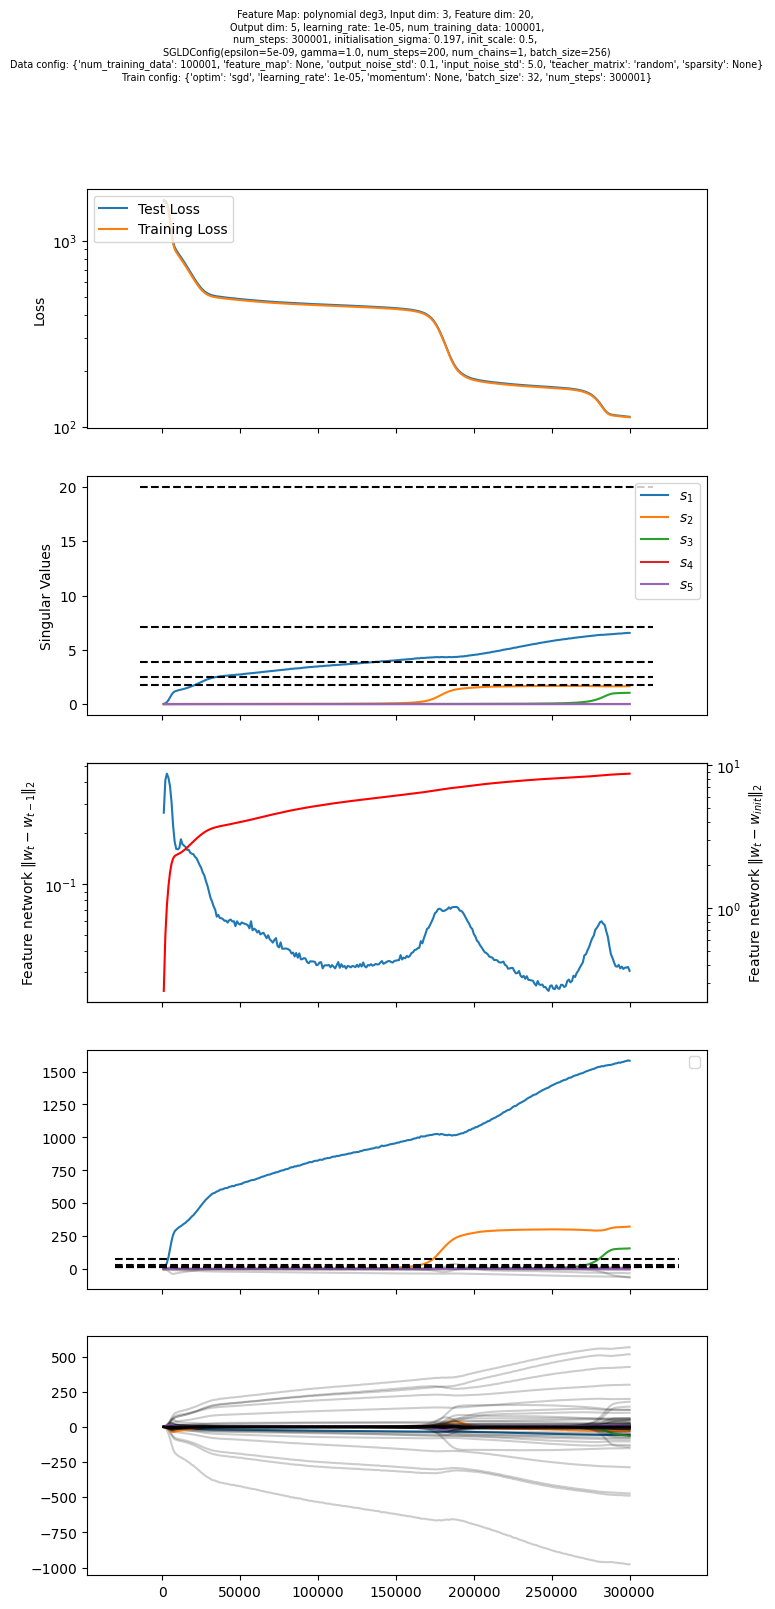

In [68]:
df_data = pd.DataFrame(records)
df = df_data
df = df[df["t"] > 10].copy(deep=True)

df["singular_values"] = df["total_matrix"].apply(lambda x: np.linalg.svd(x, compute_uv=False))
try: 

    phi_train = model_feat.apply(param[1], x_train)
    feature_correlation_matrix = phi_train.T @ phi_train / num_training_data
    eigvals, eigvecs = np.linalg.eigh(feature_correlation_matrix)
    feature_output_cross_correlation = y_train.T @ phi_train / num_training_data
    ChangeOfBasis = eigvecs @ np.diag(eigvals ** (-1/2))
    modified_feature_output_cross_correlation = feature_output_cross_correlation @ ChangeOfBasis 
    Ubar, Sbar, Vbar = np.linalg.svd(modified_feature_output_cross_correlation)
except np.linalg.LinAlgError:
    print("WARNING: SVD did not converge. Switching to using true feature correlation matrix.")
    phi_train = vmap(feature_map)(x_train)
    feature_correlation_matrix = phi_train.T @ phi_train / num_training_data
    eigvals, eigvecs = np.linalg.eigh(feature_correlation_matrix)
    feature_output_cross_correlation = y_train.T @ phi_train / num_training_data
    ChangeOfBasis = eigvecs @ np.diag(eigvals ** (-1/2))
    modified_feature_output_cross_correlation = feature_output_cross_correlation @ ChangeOfBasis 
    Ubar, Sbar, Vbar = np.linalg.svd(modified_feature_output_cross_correlation)


df["corrected_total_matrix"] = df["total_matrix"].apply(
    lambda total_mat: Ubar.T @ np.array(total_mat).T @ feature_correlation_matrix @ ChangeOfBasis @ Vbar.T
)
df["corrected_singular_values"] = df["corrected_total_matrix"].apply(
    lambda x: np.linalg.svd(x, compute_uv=False)
)

df["corrected_total_matrix_diag"] = df["corrected_total_matrix"].apply(
    lambda x: [x[i, i] for i in range(min(x.shape[0], x.shape[1]))]
)


df["potential_matrix"] = df["corrected_total_matrix"].apply(
    lambda x: x # - np.diag(Sbar)
)






fig, axes = plt.subplots(5, 1, figsize=(8, 18), sharex=True)
ax = axes[0]
if "test_loss" in df.columns:
    ax.plot(df["t"], df["test_loss"], label="Test Loss")

ax.plot(df["t"], df["train_loss"], label="Training Loss")
ax.set_ylabel("Loss")
ax.legend(loc="upper left")
ax.set_yscale("log")

    

if do_llc_estimation:
    ax = ax.twinx()
    xvals = np.array(df["t"])
    yvals = np.array(df["lambdahat"])
    maxval = 200
    mask = yvals < maxval
    xvals = xvals[mask]
    yvals = yvals[mask]
    ax.plot(xvals, yvals, "kx", alpha=0.3, label="Estimated LLC, $\hat{\lambda}(w^*)$")
    yvals = running_mean(yvals, window_size=10)
    ax.plot(xvals, yvals, "g-")
    ax.set_ylabel("Estimated LLC, $\hat{\lambda}(w^*)$")
    ax.legend(loc="upper right")


ax = axes[1]
_, singvals_true, _ = np.linalg.svd(A_true)
for i in range(min(feature_dim, output_dim)):
    ax.plot(
        df["t"],
        df["singular_values"].apply(lambda x: x[i]), 
        label="$s_{" + str(i + 1) + "}$"
    )
xmin, xmax = ax.get_xlim()
ax.hlines(singvals_true, xmin, xmax, color="k", linestyle="--")
ax.legend()
ax.set_ylabel("Singular Values")



ax = axes[2]
ax.plot(df["t"], df["dist"], label="Distance between feature network parameters")
ax.set_ylabel("Feature network $\|w_{t} - w_{t-1}\|_2$")
ax.set_yscale('log')

if "dist_init" in df.columns:
    ax = ax.twinx()
    ax.plot(df["t"], df["dist_init"], label="Distance between initialisation and feature network parameters", color="r")
    ax.set_ylabel("Feature network $\|w_{t} - w_{init}\|_2$")
    ax.set_yscale('log')



ax = axes[3]
for i in range(min(feature_dim, output_dim)):
    ax.plot(
        df["t"],
        df["corrected_singular_values"].apply(lambda x: x[i]), 
    )

    ax.plot(
        df["t"],
        df["corrected_total_matrix_diag"].apply(lambda x: x[i]), 
        color="k",
        alpha=0.2,
    )

xmin, xmax = ax.get_xlim()
ax.hlines(Sbar, xmin, xmax, color="k", linestyle="--")
ax.legend()
# for i in range(feature_dim):
#     for j in range(output_dim):
#         ax.plot(df["t"], df["total_matrix"].apply(lambda x: np.array(x)[i, j]), label=f"({i}, {j})")
# ax.set_ylabel("$[W_N \dots W_2 W_1]_{ij}$")


ax = axes[4]
for i in range(output_dim):
    for j in range(feature_dim):
        # if i != j: continue
        if i != j:
            ax.plot(
                df["t"],
                df["corrected_total_matrix"].apply(lambda x: x[i, j]), 
                color="k",
                alpha=0.2,
            )
        else:
            ax.plot(
                df["t"],
                df["corrected_total_matrix"].apply(lambda x: x[i, j]), 
                # color="k",
                # alpha=0.5,
            )


for ax in axes:
    # ax.set_yscale("log")
    # ax.set_xscale('log')
    pass

suptitle = (
    f"Feature Map: polynomial deg{degree}, "
    f"Input dim: {input_dim}, "
    f"Feature dim: {feature_dim}, \n"
    f"Output dim: {output_dim}, "
    # f"A_true singular values: {list(np.linalg.svd(A_true)[1])}, "
    f"learning_rate: {learning_rate}, "
    f"num_training_data: {num_training_data},\n"
    f"num_steps: {training_config['num_steps']}, "
    f"initialisation_sigma: {initialisation_sigma:.3f}, "
    f"init_scale: {scale_init_param}, "
    f"\n{sgld_config}"
    f"\nData config: {data_config}"
    f"\nTrain config: {training_config}"
)
# if do_llc_estimation:
#     suptitle += '\n' + ', '.join([f"{k}: {v}" for k, v in sgld_config])
fig.suptitle(suptitle, fontsize="x-small");

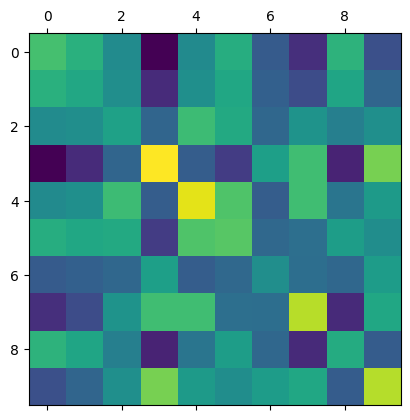

In [42]:
plt.matshow(feature_correlation_matrix, cmap="viridis")

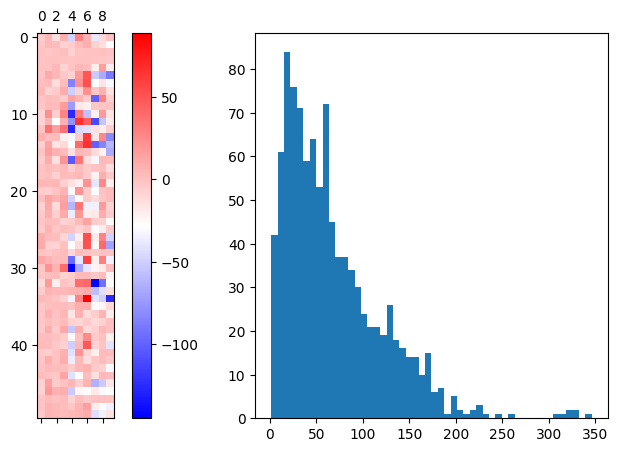

In [151]:
param_dln, param_feat = param
x_batch = x_train[:1000]
diff = model_feat.apply(param_feat, x_batch) - vmap(feature_map)(x_batch)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes[0]
cax = ax.matshow(diff[:50], cmap="bwr")
fig.colorbar(cax)

ax = axes[1]
ax.hist(np.linalg.norm(diff, axis=1), bins=50);

(10001, 3) (10001, 10) (10001, 5)


TypeError: svd() missing 1 required positional argument: 'a'

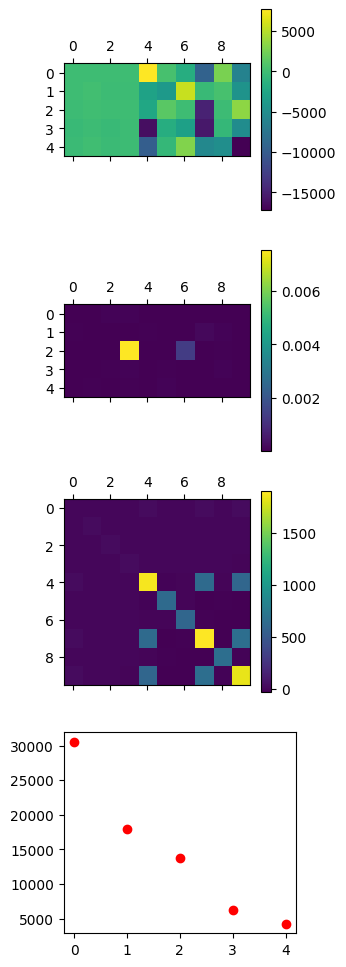

In [188]:
phi_train = vmap(feature_map)(x_train)
print(x_train.shape, phi_train.shape, y_train.shape)

cross_covariance_matrix = estimate_cross_correlation_matrix(y_train, phi_train)
covariance_matirx = estimate_cross_correlation_matrix(phi_train, phi_train)
covA = covariance_matirx @ A_true


fig, axes = plt.subplots(4, 1, figsize=(3, 12))
ax = axes[0]
cax = ax.matshow(cross_covariance_matrix, cmap='viridis')
fig.colorbar(cax)

ax = axes[1]
cax = ax.matshow(np.abs(covA.T - cross_covariance_matrix) / np.abs(cross_covariance_matrix), cmap='viridis')
fig.colorbar(cax)

ax = axes[2]
cax = ax.matshow(covariance_matirx, cmap='viridis')
fig.colorbar(cax)


ax = axes[3]
u, s, v = np.linalg.svd(cross_covariance_matrix)
ax.plot(s, "ro")

u, s, v = np.linalg.svd(A_true)
ax.plot(s, "bo")

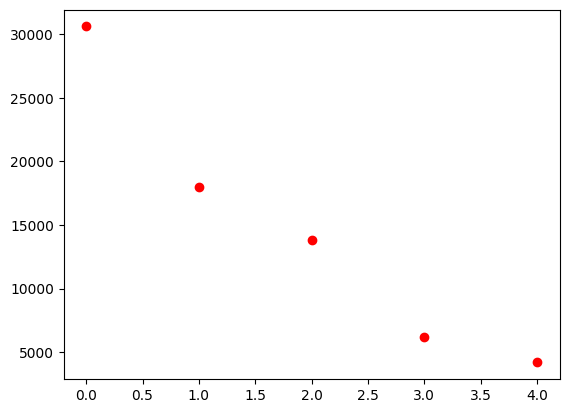

In [189]:
_, vals, _ = np.linalg.svd(covariance_matirx @ A_true)
plt.plot(np.abs(vals), "ro")

In [220]:
eigvals, eigvecs = np.linalg.eigh(covariance_matirx)
order = np.argsort(eigvals)[::-1]
eigvals = eigvals[order]
eigvecs = eigvecs[:, order]
CBasis = eigvecs @ np.diag(eigvals ** (-0.5))

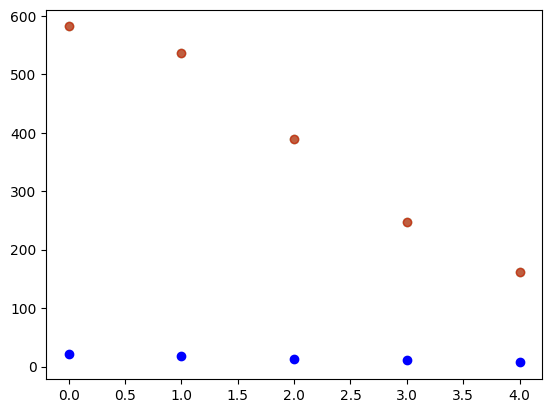

In [239]:
_, vals, _ = np.linalg.svd(A_true.T @ eigvecs @ np.diag(eigvals ** (0.5)))
plt.plot(vals, "go", alpha=0.5) 

_, vals, _ = np.linalg.svd(cross_covariance_matrix @ CBasis)
plt.plot(vals, "ro", alpha=0.5)


_, s, _ = np.linalg.svd(A_true)
plt.plot(s, "bo")

In [224]:
eigvals ** (-0.5)

array([0.01785402, 0.02809681, 0.02881386, 0.03837622, 0.03982981,
       0.04129523, 0.19836608, 0.19974768, 0.20319428, 1.5722195 ],
      dtype=float32)

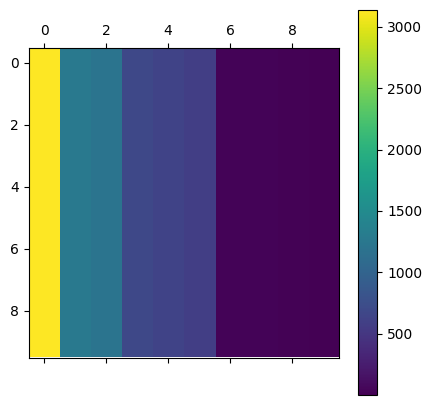

In [228]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

cax = ax.matshow((covariance_matirx @ eigvecs) / eigvecs)
fig.colorbar(cax)